In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc
from pathlib import Path
import json

In [24]:
class SweepLosses:
    def __init__(self, line, sweep, plane, num_turns, num_particles=100, nemitt_x=3.5e-6, nemitt_y=3.5e-6, result_name=None, dir=None, gaussian=False):
        self.line = line
        self.plane = plane
        self.sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
        self.num_turns = num_turns
        self.sweep_per_turn = self.sweep/self.num_turns

        self.num_particles = num_particles
        self.gaussian = gaussian

        self.nemitt_x = nemitt_x
        self.nemitt_y = nemitt_y
        if dir is None:
            self.dir = Path.cwd
        else:
            self.dir = dir

        if result_name is None:
            print("WARNING: No result_name provided, using default 'sweep_losses'")
            self.result_name = 'sweep_losses'
        else:
            self.result_name = result_name
        
        self.savedir = Path(self.dir/self.result_name/self.plane)
        Path(self.savedir).mkdir(parents=True, exist_ok=True)
        
        self.track()

    def make_particles(self):
        if not self.gaussian:
            x_spacing = np.linspace(-0.025, 0.025, int(np.sqrt(self.num_particles)))
            y_spacing = np.linspace(-0.025, 0.025, int(np.sqrt(self.num_particles)))

            X, Y = np.meshgrid(x_spacing, y_spacing, indexing='xy')
            x_norm = X.ravel()
            y_norm = Y.ravel()

            px_norm = np.zeros_like(x_norm)
            py_norm = np.zeros_like(x_norm)
            tw = self.line.twiss()
            zeta = np.ones_like(x_norm)*tw.particle_on_co.zeta
            delta = np.ones_like(x_norm)*tw.particle_on_co.delta

            return self.line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm, nemitt_x=self.nemitt_x, nemitt_y=self.nemitt_y, zeta=zeta, delta=delta)
        else:
            return xp.generate_matched_gaussian_bunch(nemitt_x=self.nemitt_x,
                                          nemitt_y=self.nemitt_y,
                                          sigma_z=0.224, num_particles=self.num_particles, line=self.line)

    def track(self):
        tw = self.line.twiss()
        tt = self.line.get_table()
        self.line.collimators.assign_optics(nemitt_x=self.nemitt_x, nemitt_y=self.nemitt_y)
        self.part = self.make_particles()

        self.line.discard_tracker()
        self.line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))
        rf_sweep = xc.RFSweep(self.line)
        rf_sweep.prepare(sweep_per_turn=self.sweep/self.num_turns)
        rf_sweep.info()
        self.line.scattering.enable()
        self.line.track(particles=self.part, num_turns=self.num_turns, time=True, with_progress=5)
        self.line.scattering.disable()
        print(f"Done sweeping RF in {self.line.time_last_track:.1f}s.")

        self.line.discard_tracker()
        self.line.build_tracker()


    @property
    def aperture_losses(self):
        loss_idxs, loss_counts = np.unique(self.part.at_element, return_counts=True)

        aper_losses = {}
        for idx, count in zip(loss_idxs, loss_counts):
            aper_losses[self.line.element_names[idx]] = int(count)

        json.dump(aper_losses, open(Path(self.savedir)/f'{self.result_name}_aper_losses.json', 'w'), indent=4)
        return aper_losses
    
    @property
    def plot_lossmap(self):
        self.ThisLM = xc.LossMap(self.line, line_is_reversed=False, part=self.part, interpolation=False)
        self.ThisLM.to_json(Path(self.savedir/f'LM_{self.result_name}.json'))
        self.ThisLM.plot(savefig=Path(self.savedir/f'LM_{self.result_name}.pdf'))
    
    @property
    def intensity_loss(self):
        fig, ax = plt.subplots(figsize=(12,6))
        turns, counts = np.unique(self.part.at_turn, return_counts=True)
        dic = {int(turn): int(count) for turn, count in zip(turns, counts)}
        dic['num_particles'] = self.num_particles
        dic['sweep_per_turn'] = self.sweep_per_turn
        json.dump(dic, open(Path(self.savedir)/f'IntensityLoss_{self.result_name}.json', 'w'), indent=4)
        ax.plot(df_to_delta(self.sweep_per_turn*turns)*1e3, 1-np.cumsum(counts)/self.num_particles, marker='o', color='royalblue')
        ax.grid()
        ax.set_xlabel(r'$\delta$ $[10^{-3}]$', fontsize=14)
        ax.set_ylabel('Normalised lost intensity', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        fig.tight_layout()
        fig.savefig(Path(self.savedir/f'IntensityLoss_{self.result_name}.pdf'), dpi=300)
        plt.show()
        return turns, counts
    

    def plot_loss_histogram(self, title="Losses per Element", top_n=None):
        # Optionally limit to top N elements by count
        aper_losses = self.aperture_losses
        items = sorted(aper_losses.items(), key=lambda x: x[1], reverse=True)
        if top_n is not None:
            items = items[:top_n]

        elements, counts = zip(*items)

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(range(len(elements)), counts, color="steelblue")
        ax.set_xticks(range(len(elements)))
        ax.set_xticklabels(elements, rotation=90)
        ax.set_xlabel("Element name")
        ax.set_ylabel("Number of losses")
        ax.set_title(title)
        fig.tight_layout()

        return fig, ax

In [3]:
cases = {
    'case0' : {},
    'case1' : {'vcak.52501.a_aper' : -1e-3},
    'case2' : {'vcak.52501.a_aper' : -1e-3, 'vcak.22501.a_aper' : -1e-3},
    'case3' : {'vcak.52501.a_aper' : -1e-3, 'vcak.22501.a_aper' : -1e-3, 'vcak.52501.b_aper' : -1e-3, 'vcak.12501.a_aper' : -1e-3},
    'case4' : {'vcak.52501.a_aper' : -1e-3, 'vcak.22501.a_aper' : -1e-3, 'vcak.52501.b_aper' : -1e-3, 'vcak.12501.a_aper' : -1e-3, 'vtto.52505.a_aper' : -1e-3},
    'case5' : {'vcak.52501.a_aper' : -1e-3, 'vcak.22501.a_aper' : -1e-3, 'vcak.52501.b_aper' : -1e-3, 'vcak.12501.a_aper' : -1e-3, 'vtto.52505.a_aper' : -1e-3, 'lsd.52505.a_aper' : -1e-3},
    'case6' : {'vcak.52501.a_aper' : -1e-3, 'vcak.22501.a_aper' : -1e-3, 'vcak.52501.b_aper' : -1e-3, 'vcak.12501.a_aper' : -1e-3, 'vtto.52505.a_aper' : -1e-3, 'lsd.52505.a_aper' : -1e-3, 'vcak.22501.b_aper' : -1e-3},
    'case6_bis' : {'vcak.52501.a_aper' : -1e-3, 'vcak.22501.a_aper' : -1e-3, 'vcak.52501.b_aper' : -1e-3, 'vcak.12501.a_aper' : -1e-3, 'vtto.52505.a_aper' : -1e-3, 'lsd.52505.a_aper' : -1e-3, 'vcak.22501.b_aper' : -1e-3, 'vcak.61101.a_aper' : 1e-3},
    'case7' : {'vcak.52501.a_aper' : -1e-3, 'vcak.22501.a_aper' : -1e-3, 'vcak.52501.b_aper' : -1e-3, 'vcak.12501.a_aper' : -1e-3, 'vtto.52505.a_aper' : -1e-3, 'lsd.52505.a_aper' : -1e-3, 'vcak.22501.b_aper' : -1e-3, 'vtto.22505.a_aper' : -1e-3},
}

In [4]:
def remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    "Remove apertures of off-momentum BPMs which give flanges as bottlenecks"
    tt = line.get_table()
    tw = line.twiss()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    aper_to_remove = [f'{name}{suffix}' for name in offmom_bpms for suffix in ('.a_aper', '.b_aper')]
    line.remove(aper_to_remove)

In [5]:
def df_to_delta(df):
    sps_gtr = 17.95
    sps_g0 = 27.643
    f0 = 200e6
    eta = 1/sps_gtr**2 - 1/sps_g0**2
    return -df/(f0*eta)

# Simulations

In [6]:
dir = Path('/Users/lisepauwels/sps_simulations/Prototyping/20251015/results/')

<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:13: SyntaxWarning: invalid escape sequence '\.'
<>:13: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:13: SyntaxWarning: invalid escape sequence '\.'
<>:13: SyntaxWarning: invalid escape sequence '\.'
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_44315/1173966935.py:9: SyntaxWarning: invalid escape sequence '\.'
  tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_44315/1173966935.py:9: SyntaxWarning: invalid escape sequence '\.'
  tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_44315/1173966935.py:13: SyntaxWarning: invalid escape sequence '\.'
  tt_v_correctors = tt.rows['mdv\..*'].rows['.*v\..*']
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipy

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 1.04e-02 -> 6.09e-04, y_rms: 9.75e-05 -> 6.67e-06
Iteration 1, x_rms: 6.09e-04 -> 2.49e-04, y_rms: 6.67e-06 -> 2.56e-06
Iteration 2, x_rms: 2.49e-04 -> 1.92e-04, y_rms: 2.56e-06 -> 8.03e-07
Iteration 3, x_rms: 1.92e-04 -> 1.77e-04, y_rms: 8.03e-07 -> 4.85e-07
Iteration 4, x_rms: 1.77e-04 -> 1.70e-04, y_rms: 4.85e-07 -> 3.51e-07
Iteration 5, x_rms: 1.70e-04 -> 1.65e-04, y_rms: 3.51e-07 -> 2.08e-07
Iteration 6, x_rms: 1.65e-04 -> 1.64e-04, y_rms: 2.08e-07 -> 1.67e-07
Iteration 7, x_rms: 1.64e-04 -> 1.64e-04, y_rms: 1.67e-07 -> 1.54e-07
Iteration 8, x_rms: 1.64e-04 -> 1.64e-04, y_rms: 1.54e-07 -> 1.53e-07
Iteration 9, x_rms: 1.64e-04 -> 1.64e-04, y_rms: 1.53e-07 -> 1.53e-07


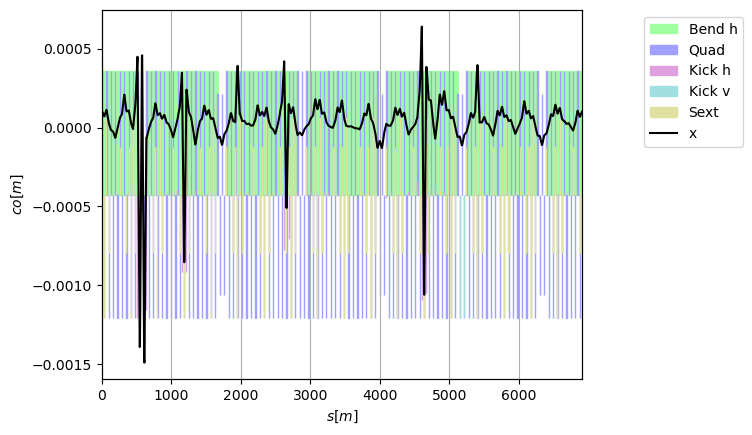

In [26]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')

tw_ref = line.twiss4d()
tt = line.get_table()
tt_monitors = tt.rows['bp.*'].rows['.*(?<!_entry)$'].rows['.*(?<!_exit)$']
line.steering_monitors_x = tt_monitors.name
line.steering_monitors_y = tt_monitors.name

tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
mask_ap_h = np.array([el.startswith('Limit') for el in tt_h_correctors.element_type])
line.steering_correctors_x = tt_h_correctors.name[~mask_ap_h]

tt_v_correctors = tt.rows['mdv\..*'].rows['.*v\..*']
mask_ap_v = np.array([el.startswith('Limit') for el in tt_v_correctors.element_type])
line.steering_correctors_y = tt_v_correctors.name[~mask_ap_v]


line['qd.52510'].shift_x = 1e-3
line['qd.22510'].shift_x = 1e-3
line['qd.50110'].shift_x = -4e-3
line['qd.31110'].shift_x = -2e-3
line['qd.20110'].shift_x = -3e-3


tw_before = line.twiss4d()

orbit_correction = line.correct_trajectory(twiss_table=tw_ref,n_micado=10, n_iter=10)

tw_after = line.twiss4d()
plt.close()
tw_after.plot('x')
plt.show()

<>:16: SyntaxWarning: invalid escape sequence '\.'
<>:16: SyntaxWarning: invalid escape sequence '\.'
<>:20: SyntaxWarning: invalid escape sequence '\.'
<>:20: SyntaxWarning: invalid escape sequence '\.'
<>:16: SyntaxWarning: invalid escape sequence '\.'
<>:16: SyntaxWarning: invalid escape sequence '\.'
<>:20: SyntaxWarning: invalid escape sequence '\.'
<>:20: SyntaxWarning: invalid escape sequence '\.'
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_44315/780753086.py:16: SyntaxWarning: invalid escape sequence '\.'
  tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_44315/780753086.py:16: SyntaxWarning: invalid escape sequence '\.'
  tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_44315/780753086.py:20: SyntaxWarning: invalid escape sequence '\.'
  tt_v_correctors = tt.rows['mdv\..*'].rows['.*v\..*']
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 7.25e-03 -> 4.21e-04, y_rms: 9.75e-05 -> 6.62e-06
Iteration 1, x_rms: 4.21e-04 -> 1.66e-04, y_rms: 6.62e-06 -> 2.33e-06
Iteration 2, x_rms: 1.66e-04 -> 1.48e-04, y_rms: 2.33e-06 -> 4.10e-07
Iteration 3, x_rms: 1.48e-04 -> 1.46e-04, y_rms: 4.10e-07 -> 1.86e-07
Iteration 4, x_rms: 1.46e-04 -> 1.44e-04, y_rms: 1.86e-07 -> 1.69e-07
Iteration 5, x_rms: 1.44e-04 -> 1.43e-04, y_rms: 1.69e-07 -> 1.56e-07
Iteration 6, x_rms: 1.43e-04 -> 1.42e-04, y_rms: 1.56e-07 -> 1.51e-07
Iteration 7, x_rms: 1.42e-04 -> 1.42e-04, y_rms: 1.51e-07 -> 1.51e-07
Iteration 8, x_rms: 1.42e-04 -> 1.42e-04, y_rms: 1.51e-07 -> 1.52e-07
Iteration 9, x_rms: 1.42e-04 -> 1.42e-04, y_rms: 1.52e-07 -> 1.51e-07
*** Maximum RMS bunch length 0.23610110400434292m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to

ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32244 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 200000001.0Hz, adding 1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = -2.812e-06 per turn.
The bucket height is 0.002995, so this implies the sweep will shift one bucket every 2129.87 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 78.7s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
case7 DPneg
{'veqd.31110.a_aper': 87, 'vcak.32501.a_aper': 9, 'veqd.50110.a_aper': 4}


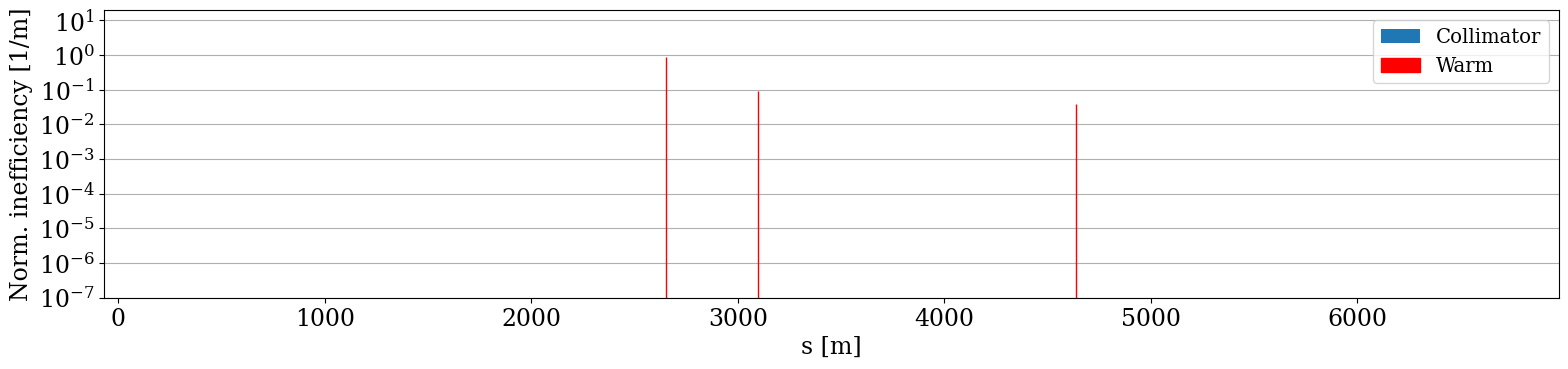

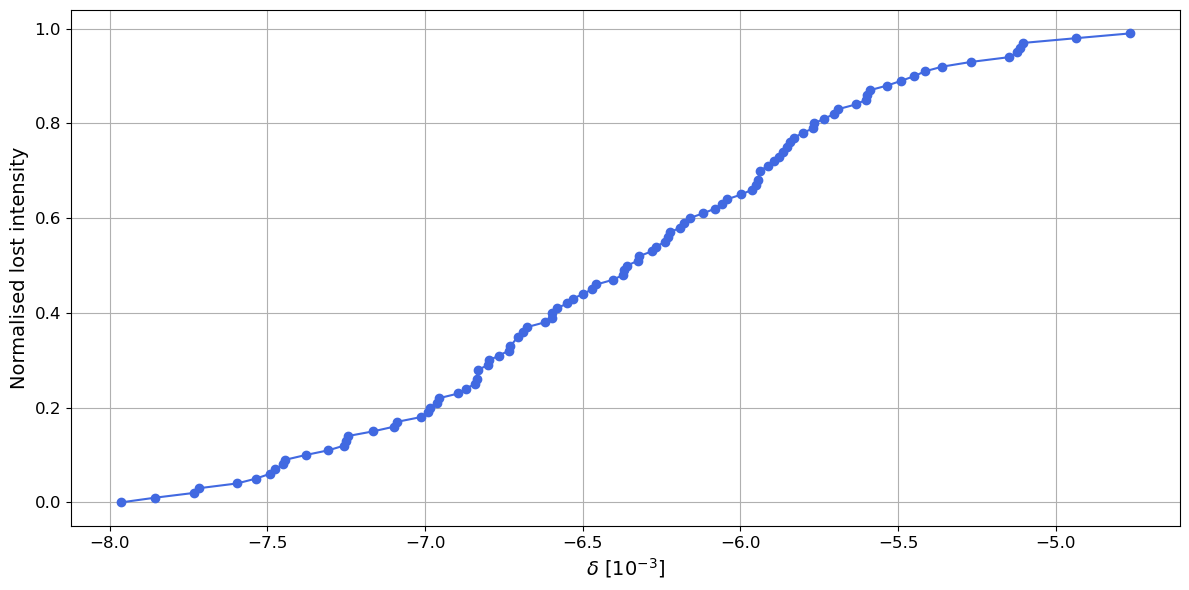

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 7.25e-03 -> 4.21e-04, y_rms: 9.75e-05 -> 6.62e-06
Iteration 1, x_rms: 4.21e-04 -> 1.66e-04, y_rms: 6.62e-06 -> 2.33e-06
Iteration 2, x_rms: 1.66e-04 -> 1.48e-04, y_rms: 2.33e-06 -> 4.10e-07
Iteration 3, x_rms: 1.48e-04 -> 1.46e-04, y_rms: 4.10e-07 -> 1.86e-07
Iteration 4, x_rms: 1.46e-04 -> 1.44e-04, y_rms: 1.86e-07 -> 1.69e-07
Iteration 5, x_rms: 1.44e-04 -> 1.43e-04, y_rms: 1.69e-07 -> 1.56e-07
Iteration 6, x_rms: 1.43e-04 -> 1.42e-04, y_rms: 1.56e-07 -> 1.51e-07
Iteration 7, x_rms: 1.42e-04 -> 1.42e-04, y_rms: 1.51e-07 -> 1.51e-07
Iteration 8, x_rms: 1.42e-04 -> 1.42e-04, y_rms: 1.51e-07 -> 1.52e-07
Iteration 9, x_rms: 1.42e-04 -> 1.42e-04, y_rms: 1.52e-07 -> 1.51e-07
*** Maximum RMS bunch length 0.23610110400434292m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to

ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32244 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.812e-06 per turn.
The bucket height is 0.002995, so this implies the sweep will shift one bucket every 2129.87 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 85.3s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
case7 DPpos
{'vcak.11101.a_aper': 2, 'vcak.21101.a_aper': 11, 'vcak.41101.a_aper': 1, 'vcak.51101.a_aper': 12, 'vcak.52501.a_aper': 9, 'vcak.61101.a_aper': 65}


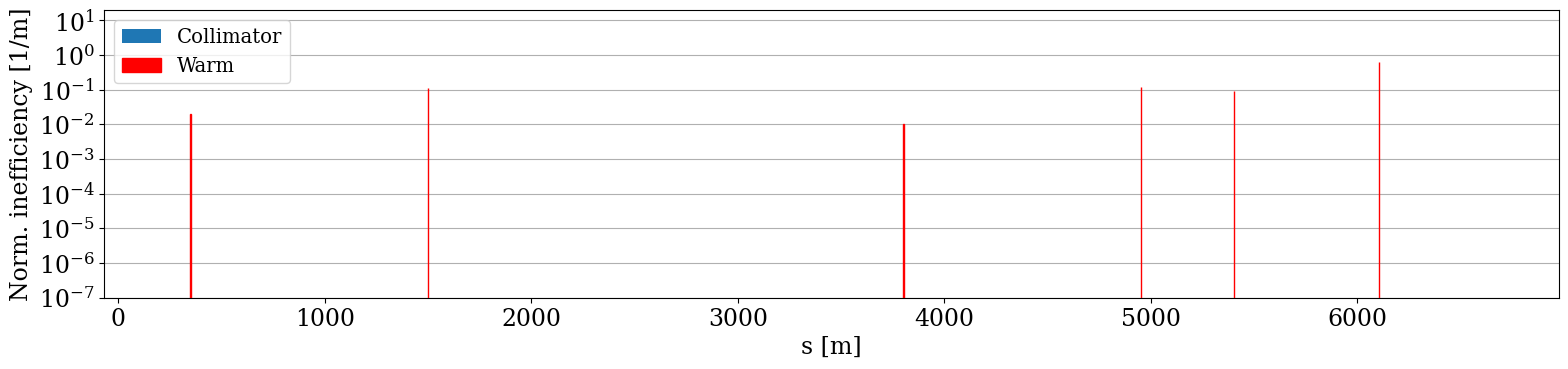

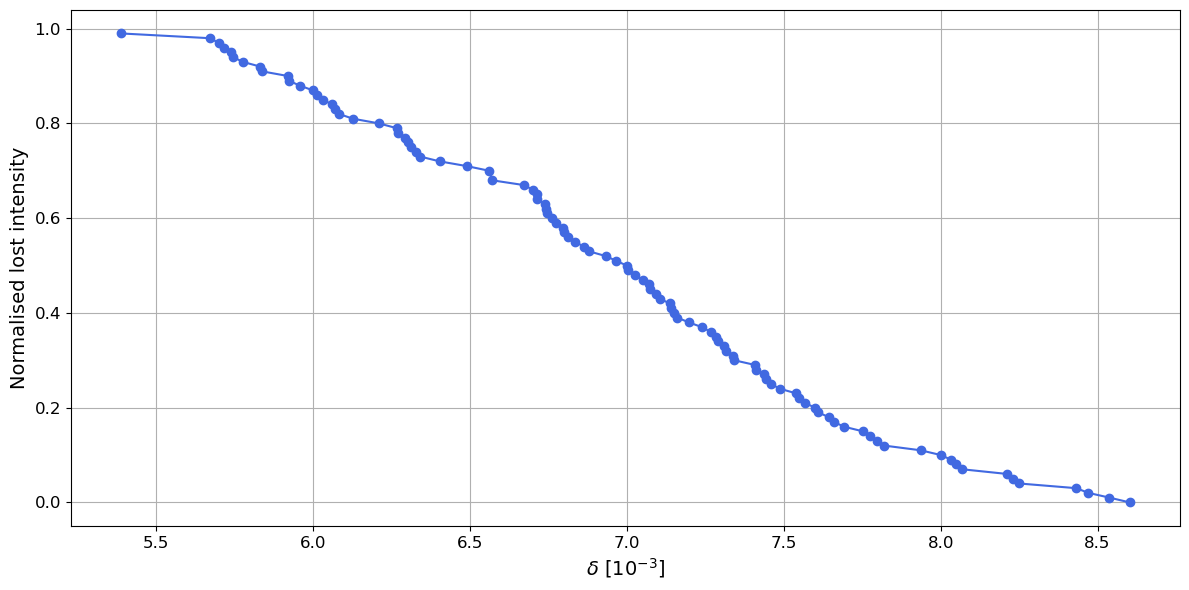

In [28]:
sim_name = 'main_bottlenecks_qdshifts_3_2_2mm'

case = 'case7'
num_particles  = 100
num_turns = 6000
sweep = 6000
for plane in ['DPneg', 'DPpos']:
    line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')

    tw_ref = line.twiss4d()
    tt = line.get_table()
    tt_monitors = tt.rows['bp.*'].rows['.*(?<!_entry)$'].rows['.*(?<!_exit)$']
    line.steering_monitors_x = tt_monitors.name
    line.steering_monitors_y = tt_monitors.name

    tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
    mask_ap_h = np.array([el.startswith('Limit') for el in tt_h_correctors.element_type])
    line.steering_correctors_x = tt_h_correctors.name[~mask_ap_h]

    tt_v_correctors = tt.rows['mdv\..*'].rows['.*v\..*']
    mask_ap_v = np.array([el.startswith('Limit') for el in tt_v_correctors.element_type])
    line.steering_correctors_y = tt_v_correctors.name[~mask_ap_v]


    line['qd.52510'].shift_x = 1e-3
    line['qd.22510'].shift_x = 1e-3
    line['qd.50110'].shift_x = -3e-3
    line['qd.31110'].shift_x = -2e-3
    line['qd.20110'].shift_x = -2e-3

    tw_before = line.twiss4d()

    orbit_correction = line.correct_trajectory(twiss_table=tw_ref,n_micado=10, n_iter=10)

    tw_after = line.twiss4d()

    remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

    context = xo.ContextCpu()
    line.vars['qph_setvalue'] = 0.5
    line.vars['qpv_setvalue'] = 0.5
    line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
    line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

    cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

    for name in cavity_names:
        line[name].frequency = 200e6
        line[name].lag = 180
    line['acl.31735'].voltage = 0 #setting 800 cav to 0V
    line['actcse.31632'].voltage = 3.0e6

    for ele, shift in cases[case].items():
        line[ele].shift_x += shift

    # for ele in ['veqd.50110.a_aper', 'veqd.50110.b_aper', 'veqd.31110.a_aper','veqd.31110.b_aper', 'veqd.20110.a_aper', 'veqd.20110.b_aper']:
    #     line[ele].shift_x += 1e-3
    for ele in ['veqd.31110.a_aper','veqd.31110.b_aper']:
        line[ele].shift_x += 2e-3

    for ele in ['veqd.50110.a_aper', 'veqd.50110.b_aper']:
        line[ele].shift_x += 3e-3
    
    for ele in ['veqd.20110.a_aper', 'veqd.20110.b_aper']:
        line[ele].shift_x += 2e-3

    sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
    SL = SweepLosses(line, sweep=sweep, plane=plane, num_turns=num_turns, num_particles=num_particles, nemitt_x=2e-6, nemitt_y=2e-6, result_name=f'{sim_name}', dir=dir, gaussian=True)

    print(case, plane)
    print(SL.aperture_losses)
    SL.plot_lossmap
    SL.intensity_loss

# Test with MD orbit

Loading line from dict:   0%|          | 0/36487 [00:00<?, ?it/s]

Done loading line from dict.           
*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004868
--> Emittance: 0.28079823319491154
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32346 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 200000001.0Hz, adding 1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = -2.809e-06 per turn.
The bucket height is 0.002993, so this implies the sweep will shift one bucket every 2130.86 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 78.1s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
case7 DPneg
{'vcak.12501.a_aper': 6, 'veqd.20110.a_aper': 32, 'vcak.22501.a_aper': 16, 'vcak.62501.a_aper': 46}


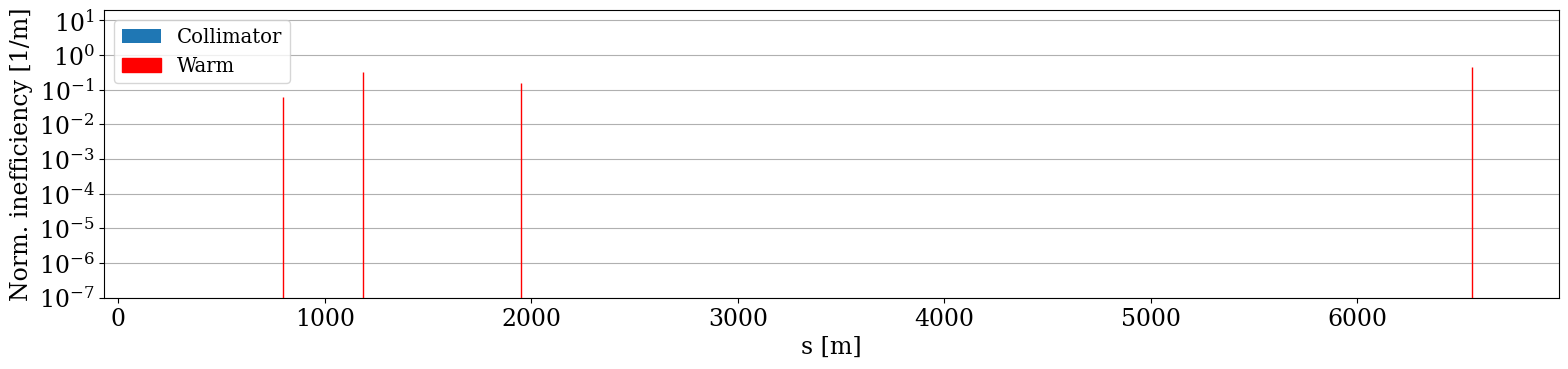

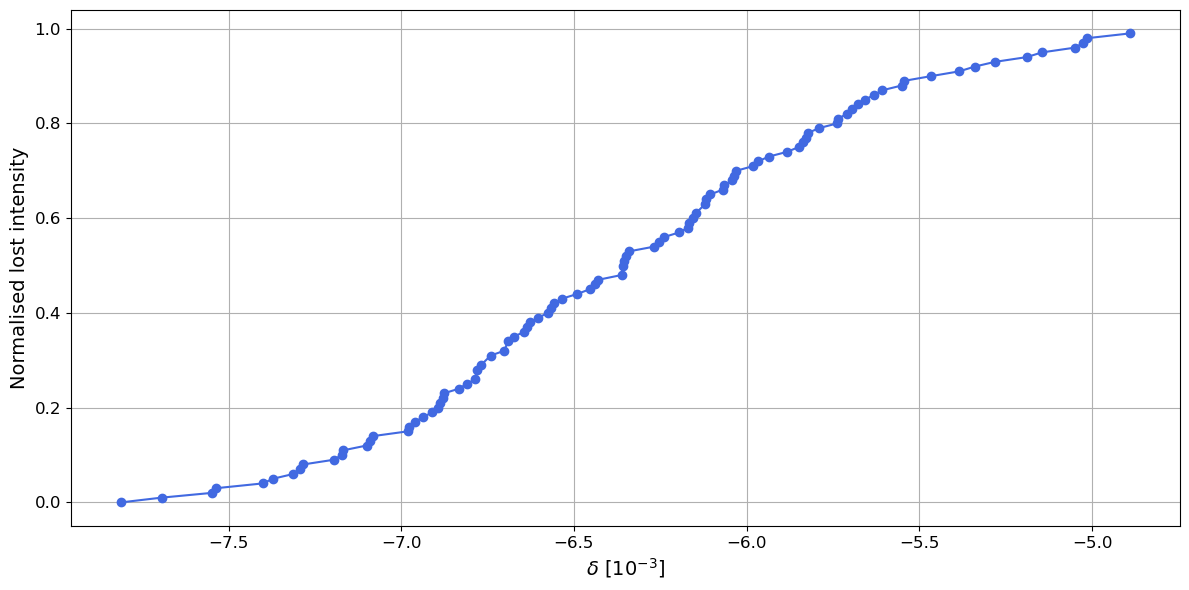

Loading line from dict:   0%|          | 0/36487 [00:00<?, ?it/s]

Done loading line from dict.           
*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004868
--> Emittance: 0.28079823319491154
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32346 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.809e-06 per turn.
The bucket height is 0.002993, so this implies the sweep will shift one bucket every 2130.86 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 85.1s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
case7 DPpos
{'vcak.21101.a_aper': 1, 'vcak.51101.a_aper': 61, 'vcak.52501.a_aper': 7, 'vcak.61101.a_aper': 31}


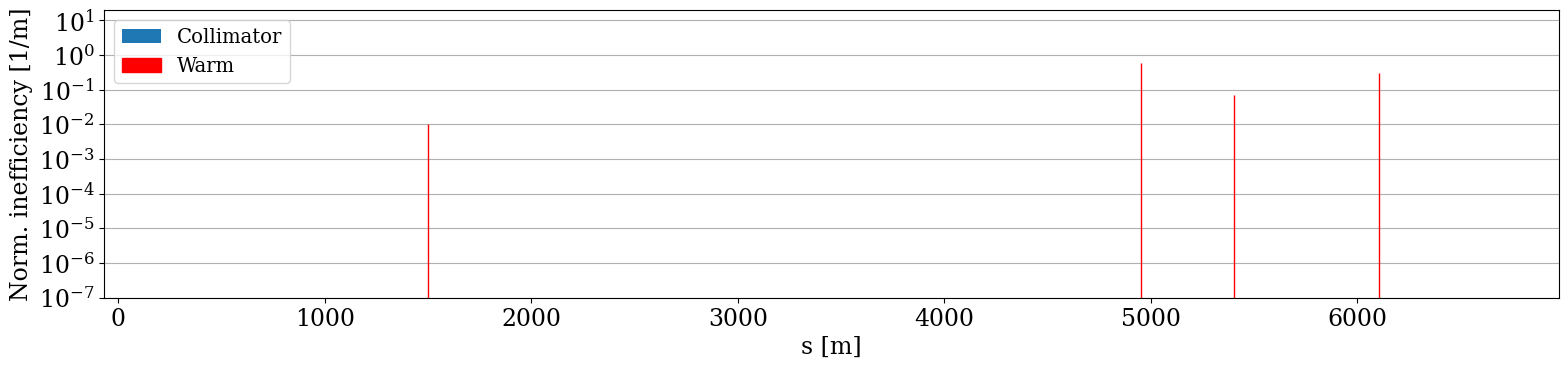

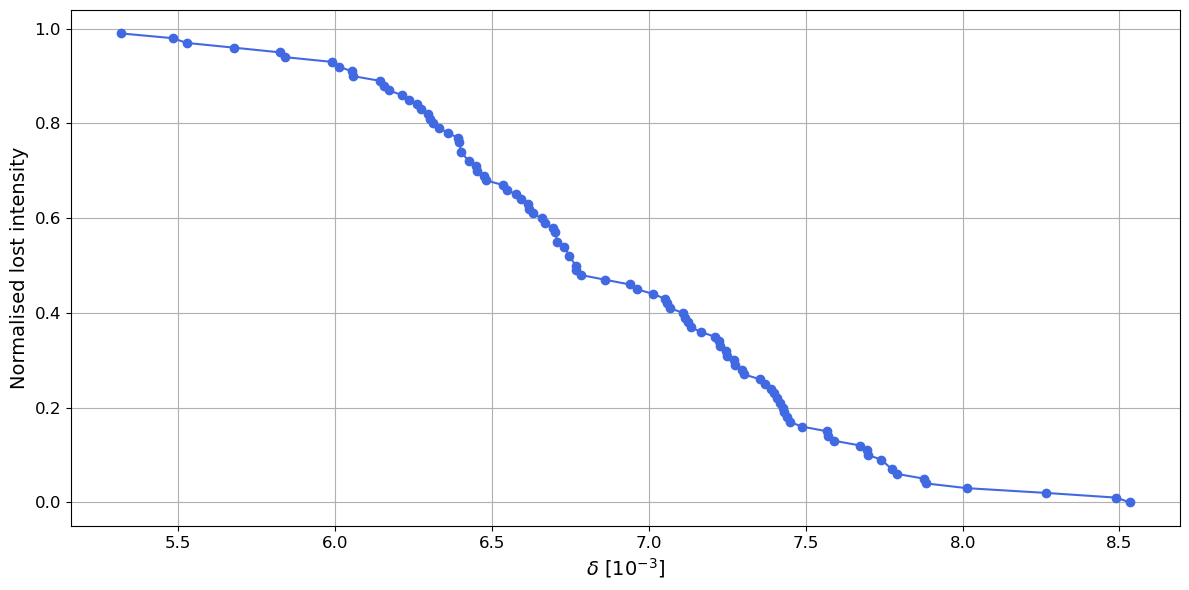

In [51]:
sim_name = 'orbit_md_apershift_3_2_3mm_v3'

case = 'case7'
num_particles  = 100
num_turns = 6000
sweep = 6000
for plane in ['DPneg', 'DPpos']:
    line = xt.Line.from_json('../../injection_lines/sps_orbit_md_20250616_v3.json')

    # tw_ref = line.twiss4d()
    # tt = line.get_table()
    # tt_monitors = tt.rows['bp.*'].rows['.*(?<!_entry)$'].rows['.*(?<!_exit)$']
    # line.steering_monitors_x = tt_monitors.name
    # line.steering_monitors_y = tt_monitors.name

    # tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
    # mask_ap_h = np.array([el.startswith('Limit') for el in tt_h_correctors.element_type])
    # line.steering_correctors_x = tt_h_correctors.name[~mask_ap_h]

    # tt_v_correctors = tt.rows['mdv\..*'].rows['.*v\..*']
    # mask_ap_v = np.array([el.startswith('Limit') for el in tt_v_correctors.element_type])
    # line.steering_correctors_y = tt_v_correctors.name[~mask_ap_v]


    # line['qd.52510'].shift_x = 1e-3
    # line['qd.22510'].shift_x = 1e-3
    # line['qd.50110'].shift_x = -3e-3
    # line['qd.31110'].shift_x = -2e-3
    # line['qd.20110'].shift_x = -2e-3

    # tw_before = line.twiss4d()

    # orbit_correction = line.correct_trajectory(twiss_table=tw_ref,n_micado=10, n_iter=10)

    # tw_after = line.twiss4d()

    remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

    context = xo.ContextCpu()
    line.vars['qph_setvalue'] = 0.5
    line.vars['qpv_setvalue'] = 0.5
    line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
    line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

    cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

    for name in cavity_names:
        line[name].frequency = 200e6
        line[name].lag = 180
    line['acl.31735'].voltage = 0 #setting 800 cav to 0V
    line['actcse.31632'].voltage = 3.0e6

    # for ele, shift in cases[case].items():
    #     line[ele].shift_x += shift

    # for ele in ['veqd.50110.a_aper', 'veqd.50110.b_aper', 'veqd.31110.a_aper','veqd.31110.b_aper', 'veqd.20110.a_aper', 'veqd.20110.b_aper']:
    #     line[ele].shift_x += 2e-3
    # line['vcak.52501.a_aper'].shift_x = 0
    for ele in ['veqd.31110.a_aper','veqd.31110.b_aper']:
        line[ele].shift_x += 2e-3

    for ele in ['veqd.50110.a_aper', 'veqd.50110.b_aper']:
        line[ele].shift_x += 3e-3
    
    for ele in ['veqd.20110.a_aper', 'veqd.20110.b_aper']:
        line[ele].shift_x += 3e-3

    sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
    SL = SweepLosses(line, sweep=sweep, plane=plane, num_turns=num_turns, num_particles=num_particles, nemitt_x=2e-6, nemitt_y=2e-6, result_name=f'{sim_name}', dir=dir, gaussian=True)

    print(case, plane)
    print(SL.aperture_losses)
    SL.plot_lossmap
    SL.intensity_loss

In [37]:
line_md = xt.Line.from_json('../../injection_lines/sps_orbit_md_20250616_v3.json')
line_ref = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')

Loading line from dict:   0%|          | 0/36487 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [38]:
tw_md = line_md.twiss()
tw_ref = line_ref.twiss()

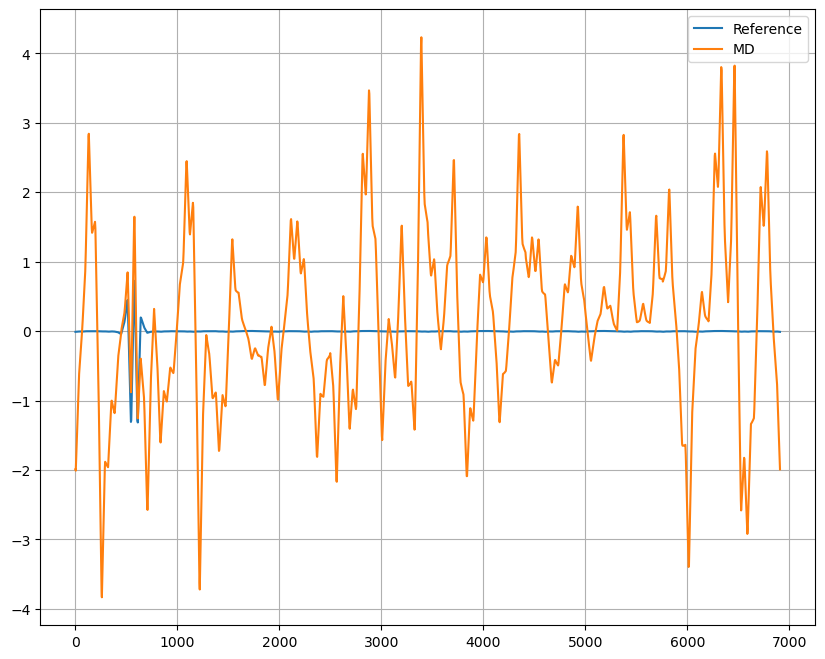

In [44]:
plt.close('all')
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(tw_ref.s, tw_ref.x*1e3, label='Reference', color='tab:blue')
ax.plot(tw_md.s, tw_md.x*1e3, label='MD', color='tab:orange')
ax.legend()
ax.grid()
plt.show()